In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


from mlxtend.feature_selection import SequentialFeatureSelector

pd.set_option('display.max_columns', None)

#### Load Data

In [26]:
data = pd.read_csv('data/valorant_team_data.csv')
data_teamless = data.iloc[:, 1:]

In [27]:
data_teamless.head()

,ACS,ADR,HS_Percent,FirstKills,FirstDeaths,Games Played,Team_TotalRounds,Team_RoundsFirstHalf,Team_RoundsSecondtHalf,Team_RoundsOT,Team_PistolWon,WinRate,Team_Eco_Conv,Team_SemiEco_Conv,Team_SemiBuy_Conv,Team_FullBuy_Conv
0,210.519185,136.751381,0.230083,2.111511,2.022099,168,11.312057,6.609929,4.489362,0.212766,1.063830,65.248227,39.401496,20.000000,58.364312,60.957746
1,214.374233,137.646626,0.264920,2.193865,1.904294,164,11.509202,6.981595,4.325153,0.202454,1.110429,63.803681,41.101695,20.276498,60.358891,62.217861
2,203.372035,130.253769,0.252010,2.128589,2.066583,166,11.654867,6.637168,4.814159,0.203540,1.168142,64.601770,45.510836,22.413793,56.532067,60.583446
3,210.984946,134.413636,0.198000,2.084946,2.038596,186,11.366864,6.508876,4.745562,0.112426,1.130178,62.721893,44.175824,22.222222,57.412399,60.291262
4,208.746939,133.449315,0.228476,2.236735,1.946853,147,11.419580,6.461538,4.741259,0.216783,1.118881,63.636364,43.002545,27.567568,54.409567,60.287356


### Data Exploration

####  Histogram Density Graphs

<Figure size 1000x1000 with 0 Axes>

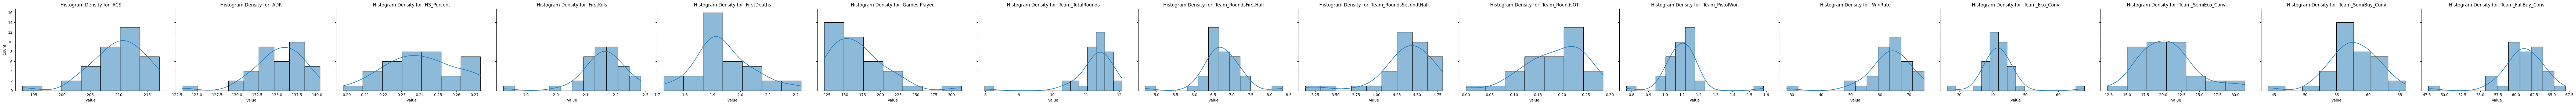

In [28]:
plt.figure(figsize=(10, 10))
# Melt the DataFrame to convert it to long format
df_melted = data_teamless.melt(var_name='Columns')

# Create the FacetGrid with histogram density plots
g = sns.FacetGrid(df_melted, col='Columns', sharex=False, height=4, aspect=1.5)
g.map(sns.histplot, 'value', kde=True)

# Add titles to the subplots
for ax in g.axes.flat:
    ax.set_title('Histogram Density for ' + ax.get_title().split('=')[1])

plt.tight_layout()  # To prevent overlapping of subplots
plt.show()

#### Check Multicollinerity

Due to high dimensionality of our data (16 variables), we must check for relationships between independant variables. This gives us the smallest number of variables that can explain the dependant variable (WinRate). \
\
I will check for multicollineirity by \
(i) Correlation Map \
(ii) Variance Inflation Factor

#### (i) Check By Correlation Map

This checks bivariate correlation between variables

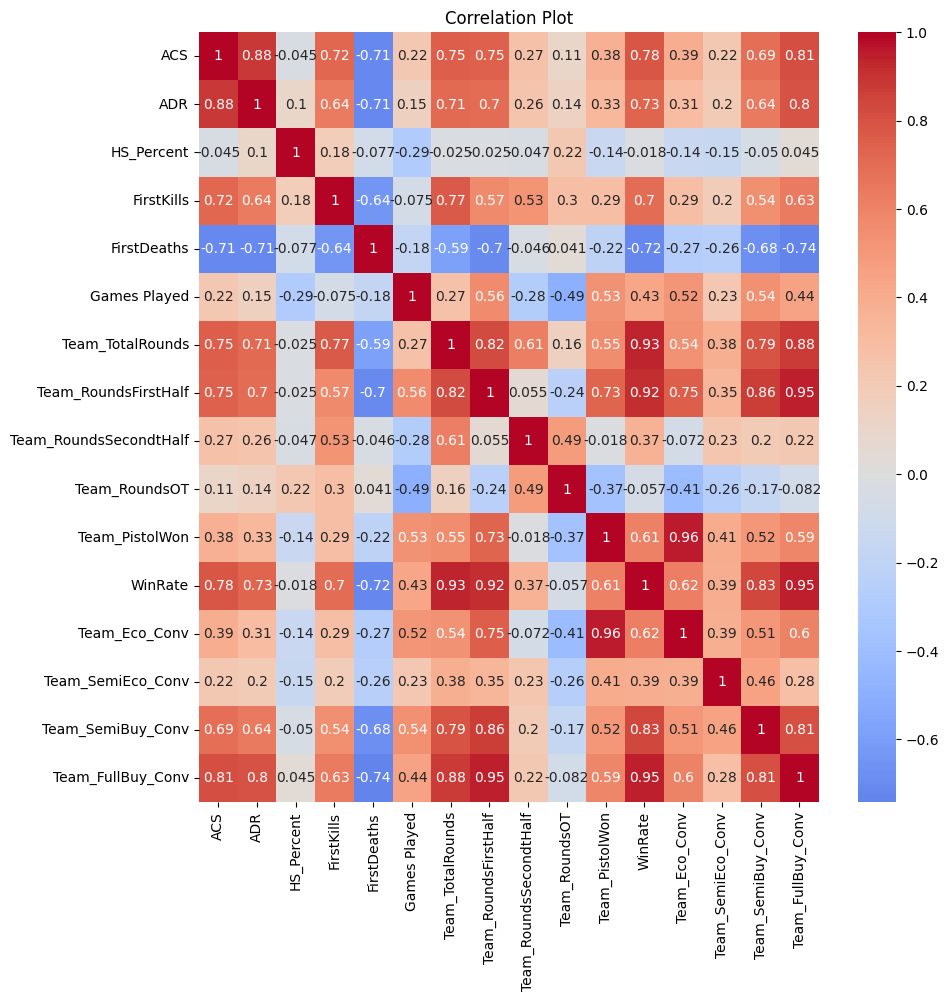

In [29]:
correlation_matrix = data_teamless.corr()
plt.figure(figsize=(10, 10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

plt.title("Correlation Plot")
plt.show()

From the correlation heatmap, HS_Percent, Team_RoundsOT, Team_SemiEco_Conv have no very weak correlation with other variables. Weak positive correlation exists in Team_RoundsSecondtHalf,

#### (ii) Check by Variance Inflation Factor (VIF)

In [30]:
# Adding a constant column to the data (required for VIF calculation)
data_with_constant = add_constant(data_teamless)

vif = pd.DataFrame()
vif['Variable'] = data_with_constant.columns
vif['VIF'] = [variance_inflation_factor(data_with_constant.values, i) for i in range(data_with_constant.shape[1])]
# Formatting VIF values to display in a more readable format
vif['VIF'] = vif['VIF'].apply(lambda x: '{:.2f}'.format(x))

print(vif)

                  Variable       VIF
0                    const  13598.00
1                      ACS      9.98
2                      ADR      7.30
3               HS_Percent      2.33
4               FirstKills      7.99
5              FirstDeaths      9.34
6             Games Played      4.11
7         Team_TotalRounds       inf
8     Team_RoundsFirstHalf       inf
9   Team_RoundsSecondtHalf       inf
10           Team_RoundsOT       inf
11          Team_PistolWon     17.33
12                 WinRate     32.60
13           Team_Eco_Conv     19.94
14       Team_SemiEco_Conv      1.91
15       Team_SemiBuy_Conv     16.42
16       Team_FullBuy_Conv     59.09


C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF = 1, indicates no correlation between independant variable and others\
VIF exceeding 5 - 10, indicates high multicollinearity between independant variable and others

### Feature Selection

I will use 'mlxtend' library to implement two methods of feature selection. \
\
(i) Foward Selection - starts with an empty model and iteratively adds variables to the model until no further improvement is made. \
(ii) Backward Selection - starts with a model that includes all variables and iteratively removes variables until no further improvement is made.

#### (i) Forward Selection

In [31]:
target_var = data_teamless['WinRate'] # Dependant variable
predictor_var = data_teamless.drop(columns=['WinRate']) # Independant variables

# Create a linear regression model
model = LinearRegression()

# Perform forward selection using SequentialFeatureSelector
forward_selector = SequentialFeatureSelector(model, k_features='best', forward=True, verbose=2)
forward_selector.fit(predictor_var, target_var)

# Get the selected feature indices
forward_selected_feature_indices = forward_selector.k_feature_idx_

# Get the names of the selected features
forward_selected_features = predictor_var.columns[list(forward_selected_feature_indices)]
print("Selected predictors:", forward_selected_features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished

[2023-08-05 14:05:40] Features: 1/15 -- score: 0.7716725438575067[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished

[2023-08-05 14:05:40] Features: 2/15 -- score: 0.8682438930019091[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished

[2023-08-05 14:05:40] Features: 3/15 -- score: 0.8882580642183197[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

Selected predictors: Index(['Team_TotalRounds', 'Team_Eco_Conv', 'Team_SemiEco_Conv',
       'Team_FullBuy_Conv'],
      dtype='object')


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished

[2023-08-05 14:05:41] Features: 8/15 -- score: 0.8792700102391245[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s finished

[2023-08-05 14:05:41] Features: 9/15 -- score: 0.8682100310565677[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished

[2023-08-05 14:05:41] Features: 10/15 -- score: 0.8518778648202876[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished

[2023-08-05 14:05:41] Features: 11/15

In [32]:
# New dataframe with selected variables
data_forward_selected = data[forward_selected_features]

#### Forward Selected Data Correlation Map

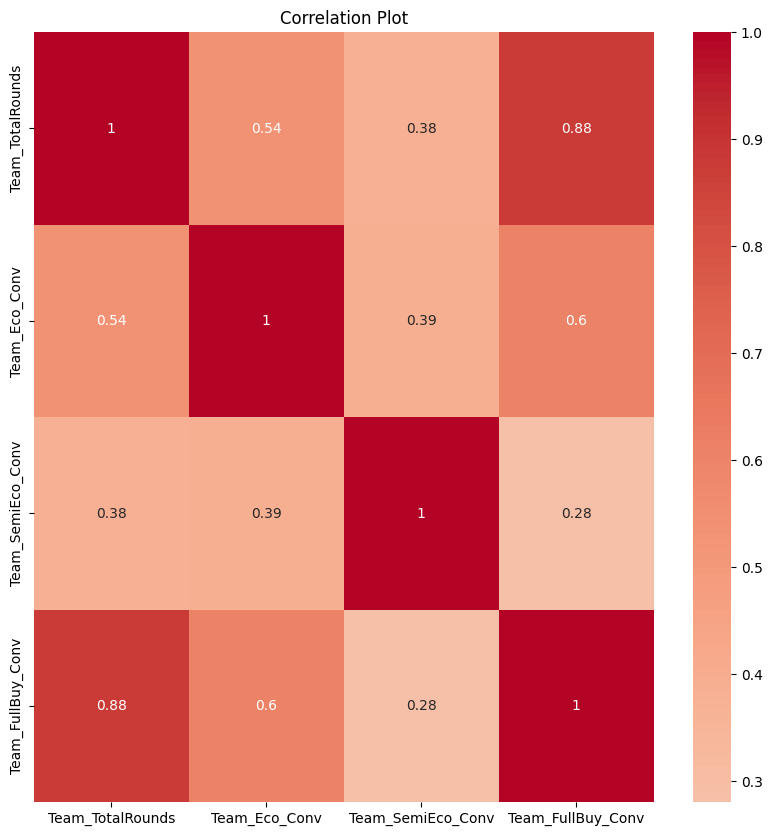

In [33]:
correlation_matrix = data_forward_selected.corr()
plt.figure(figsize=(10, 10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

plt.title("Correlation Plot")
plt.show()

#### Build Linear Regression Model (Predicts Win Rate)

In [34]:
# Split the data into train and test sets
X_train, X_test,\
    y_train, y_test = train_test_split(
        data_forward_selected, target_var,
        test_size=0.3,
        random_state=42)

In [35]:
lin_reg_forward = linear_model.LinearRegression()
lin_reg_forward.fit(X_train, y_train)
 
# Make predictions using the test set
y_pred = lin_reg_forward.predict(X_test)

#### Evaluate the foward selection model

In [36]:
# Evaluate the model
r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("R-squared:", r_squared)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

R-squared: 0.8654567390464246
Mean Squared Error: 4.739646848762109
Mean Absolute Error: 1.8994887168470829


#### Visualize Forward Selection Predictions

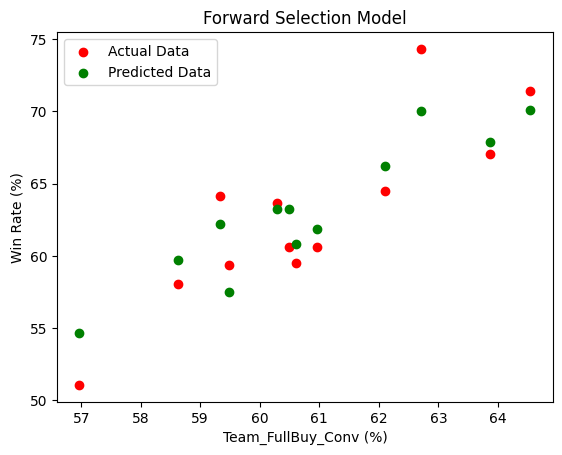

In [40]:
plt.scatter(X_test['Team_FullBuy_Conv'].values, y_test, color = 'red', label='Actual Data')
plt.scatter(X_test['Team_FullBuy_Conv'].values, y_pred, color = 'green', label='Predicted Data')
plt.title('Forward Selection Model')
plt.xlabel('Team_FullBuy_Conv (%)')
plt.ylabel('Win Rate (%)')
plt.legend()
plt.show() 

#### (ii) Backward Elimination

In [13]:
model = LinearRegression()

# Perform backward elimination using SequentialFeatureSelector
backward_selector = SequentialFeatureSelector(model, k_features='best', forward=False, floating=False, scoring='neg_mean_squared_error', verbose=2)
backward_selector.fit(predictor_var, target_var)

# Get the selected feature indices
selected_feature_indices = backward_selector.k_feature_idx_

# Get the names of the selected features
backward_selected_features = predictor_var.columns[list(selected_feature_indices)]

print("Selected predictors:", backward_selected_features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished

[2023-08-05 14:01:38] Features: 14/1 -- score: -6.053551387912617[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished

[2023-08-05 14:01:38] Features: 13/1 -- score: -5.345846443559568[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished

[2023-08-05 14:01:38] Features: 12/1 -- score: -4.945448517804896[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

Selected predictors: Index(['FirstDeaths', 'Games Played', 'Team_TotalRounds',
       'Team_RoundsFirstHalf', 'Team_SemiEco_Conv', 'Team_SemiBuy_Conv'],
      dtype='object')


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished

[2023-08-05 14:01:38] Features: 7/1 -- score: -3.8852904331879925[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s finished

[2023-08-05 14:01:38] Features: 6/1 -- score: -3.6856178459267914[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished

[2023-08-05 14:01:38] Features: 5/1 -- score: -3.7904277804208832[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished

[2023-08-05 14:01:38] Features: 4/1 --

In [14]:
# Dataframe with selected variables
data_backward_selected = data[backward_selected_features]

#### Backward Selected Data Correlation Map

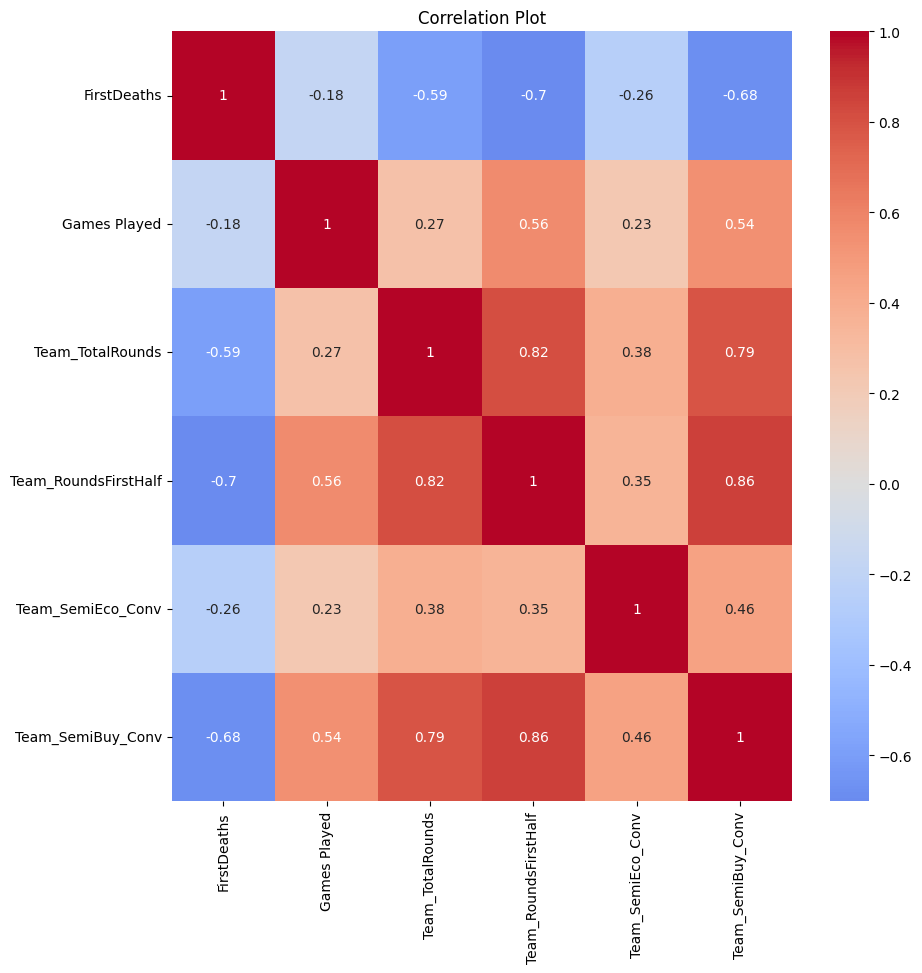

In [15]:
correlation_matrix = data_backward_selected.corr()
plt.figure(figsize=(10, 10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

plt.title("Correlation Plot")
plt.show()

#### Build Linear Regression Model (Predicts Win Rate)

In [16]:
# Split the data into train and test sets
X_train, X_test,\
    y_train, y_test = train_test_split(
        data_backward_selected, target_var,
        test_size=0.3,
        random_state=42)

In [17]:
lin_reg_backward = linear_model.LinearRegression()
lin_reg_backward.fit(X_train, y_train)
 
# Make predictions using the test set
y_pred = lin_reg_backward.predict(X_test)

#### Evaluate the backward selection model

In [18]:
# Evaluate the model
r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("R-squared:", r_squared)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

R-squared: 0.8953454123568906
Mean Squared Error: 3.686738250697795
Mean Absolute Error: 1.450428997512298


#### Visualize Backward Selection Predictions

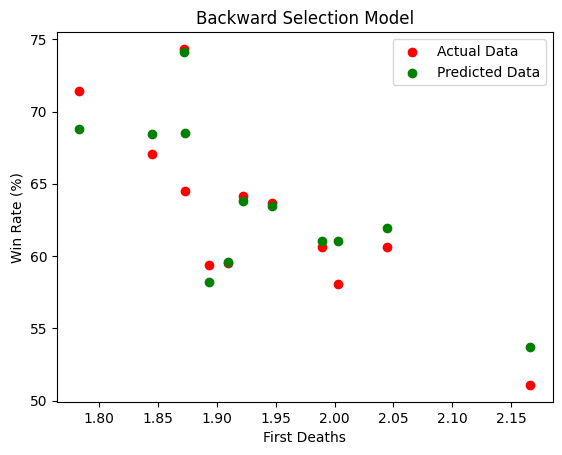

In [24]:
plt.scatter(X_test['FirstDeaths'].values, y_test, color = 'red', label='Actual Data')
plt.scatter(X_test['FirstDeaths'].values, y_pred, color = 'green', label='Predicted Data')
plt.title('Backward Selection Model')
plt.xlabel('First Deaths')
plt.ylabel('Win Rate (%)')
plt.legend()
plt.show() 

### Evaluate Forward vs. Backward Models

I will use the Akaike Information Criterion to assess the goodness of fit of the two models. The lower AIC value is preferred.

####  Akaike Information Criterion

In [41]:
# Get the number of parameters (k) for each model
k_forward = len(forward_selector.k_feature_idx_) + 1
k_backward = len(backward_selector.k_feature_idx_) + 1

# Calculate the likelihood (L) for each model
mse_forward = abs(forward_selector.k_score_)
mse_backward = abs(backward_selector.k_score_)

# Calculate the AIC for each model
aic_forward = 2 * k_forward - 2 * (mse_forward)
aic_backward = 2 * k_backward - 2 * (mse_backward)

print("AIC Forward Selection:", aic_forward)
print("AIC Backward Selection:", aic_backward)

AIC Forward Selection: 8.202027627546416
AIC Backward Selection: 6.628764308146417


By AIC, I would select the backward selection model. Which is supported by its lower R-squared value compared to forward selection model.

### Random Forest Regression

Checking for multicollinearity is not necessary for Random Forest. I will use the full dataset for training.

In [42]:
X = data_teamless.drop(columns=['WinRate'])
y = data_teamless['WinRate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Hyperparameter Tuning with GridSearchCV

In [43]:
random_forest_tuning = RandomForestRegressor(random_state = 42)
rf_param_grid = {
   'n_estimators': [100, 200, 500],
   'max_features': ['auto', 'sqrt', 'log2'],
   'max_depth' : [4,5,6,7,8],
   'criterion' :['squared_error', 'absolute_error']
}

rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with the random forest model and the hyperparameter grid
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, scoring='neg_mean_squared_error', cv=5, error_score='raise')

try:
    # Perform the grid search on the training data
    rf_grid_search.fit(X_train, y_train)
except Exception as e:
    print("Error during grid search:", e)

# Get the best hyperparameters and the corresponding best model
rf_best_params = rf_grid_search.best_params_
rf_best_model = rf_grid_search.best_estimator_


C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_f

C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_f

C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_f

C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_f

C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_f

C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_f

C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_f

In [44]:
# Make predictions
y_pred = rf_best_model.predict(X_test)

#### Evaluate RandomForestRegressor Model

In [45]:
print("Best Hyperparameters:", rf_best_params)

# Evaluate the model
rf_r_squared = r2_score(y_test, y_pred)
rf_mse = mean_squared_error(y_test, y_pred)
rf_mae = mean_absolute_error(y_test, y_pred)

print("R-squared:", rf_r_squared)
print("Mean Squared Error:", rf_mse)
print("Mean Absolute Error:", rf_mae)

Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100}
R-squared: 0.8728781160357175
Mean Squared Error: 6.114995084420885
Mean Absolute Error: 1.9054928755256269


#### Visualize RandomForest Predictions

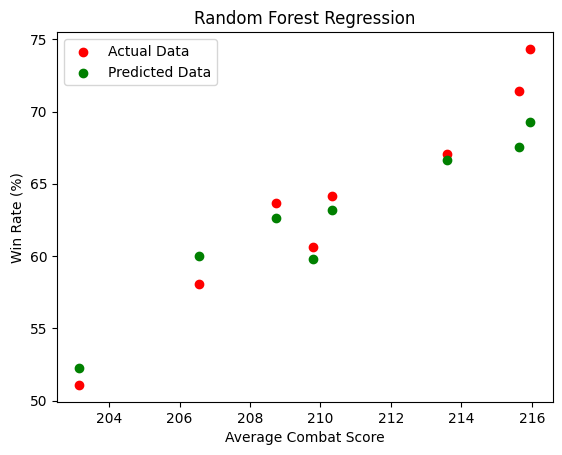

In [46]:
plt.scatter(X_test['ACS'].values, y_test, color = 'red', label='Actual Data')
plt.scatter(X_test['ACS'].values, y_pred, color = 'green', label='Predicted Data')
plt.title('Random Forest Regression')
plt.xlabel('Average Combat Score')
plt.ylabel('Win Rate (%)')
plt.legend()
plt.show() 

### XGBoost Regressor Model

In [47]:
xgb_model = xgb.XGBRegressor()

# Define the hyperparameter grid you want to search
xgb_param_grid = {
    'n_estimators': [50, 100, 150],                # Number of boosting rounds
    'max_depth': [3, 5, 7],                        # Maximum depth of the trees
    'learning_rate': [0.01, 0.1, 0.3],             # Step size shrinkage for each boosting round
    'subsample': [0.8, 1.0],                       # Subsample ratio of the training instances
    'colsample_bytree': [0.8, 1.0]                 # Subsample ratio of columns when constructing each tree
}

In [48]:
# Initialize GridSearchCV with the XGBoost model and the hyperparameter grid
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, scoring='neg_mean_squared_error', cv=5)

# Perform the grid search on the training data
xgb_grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding best model
xgb_best_params = xgb_grid_search.best_params_
xgb_best_model = xgb_grid_search.best_estimator_

# Make predictions
y_pred = xgb_best_model.predict(X_test)

#### Evaluate XGBoost Model

In [49]:
# Evaluate the model
xgb_r_squared = r2_score(y_test, y_pred)
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_mae = mean_absolute_error(y_test, y_pred)

print("Best Hyperparameters:", xgb_best_params)
print("R-squared:", xgb_r_squared)
print("Mean Squared Error:", xgb_mse)
print("Mean Absolute Error:", xgb_mae)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
R-squared: 0.7806048052444349
Mean Squared Error: 10.553655245172369
Mean Absolute Error: 2.603656462528239


#### Visualize XGBoost Predictions

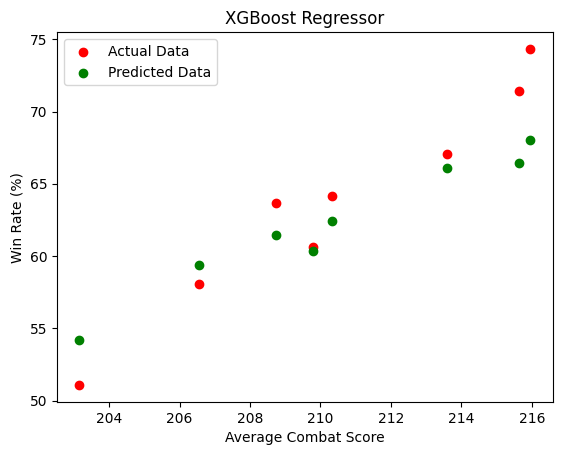

In [50]:
plt.scatter(X_test['ACS'].values, y_test, color = 'red', label='Actual Data')
plt.scatter(X_test['ACS'].values, y_pred, color = 'green', label='Predicted Data')
plt.title('XGBoost Regressor')
plt.xlabel('Average Combat Score')
plt.ylabel('Win Rate (%)')
plt.legend()
plt.show() 